# Know Your Odds: How Likely Are You to Win the Lottery?

## Table of Contents

* [Introduction](#intorduction)
* [Goal](#goal)
* [Summary](#summary)
* [The Data](#the_data)
* [Core Functions](#core_functions)
* [One Ticket Probability](#one_ticket_probability)
* [Historical Data Check for Canada Lottery](#historical_data_check)
  * [Functions for Historical Data Check](#functions_for_historical_data_check)
  * [Finding Winning Tickets](#finding_winning_tickets)
* [Multi-ticket Probability](#multi_ticket_probability)
* [Fewer Winning Numbers](#fewer_winning_numbers)
  * [Exact number of winning numbers](#exact_number)
  * [Minimum number of winning numbers](#minimum_number)
* [Next Steps](#next_steps)
* [Conclusion](#conclusion)

## Introduction  <a name="introduction"></a>

A medical institute that aims to prevent and treat gambling addictions wants to build a dedicated mobile app to help lottery addicts better estimate their chances of winning. The institute has a team of engineers that will build the app, but they need us to create the logical core of the app and calculate probabilities.

## Goal  <a name="goal"></a>

For the first version of the app, the institute wants us to focus on thenational [6/49 lottery](https://en.wikipedia.org/wiki/Lotto_6/49) game in Canada. They want us to use historical data and probability to build functions that enable users to answer questions like:

* What is the probability of winning the big prize with a single ticket?
* What is the probability of winning the big prize if we play 40 different tickets (or any other number)?
* What is the probability of having at least five (or four, or three, or two) winning numbers on a single ticket?

## Summary  <a name="summary"></a>

Don't play the lottery. You'll lose your money.

## The Data <a name="the_data"></a>

[The data set](https://www.kaggle.com/datascienceai/lottery-dataset) has data for 3,665 drawings, dating from 1982 to 2018.

The following is some boilerplate code that loads the required libraries, reads the data and displays some initial information about it:

In [18]:
import pandas as pd
import numpy as np
# Reading the file
historical_data = pd.read_csv("649.csv")

# Allow Jupyter notebook to generate plots and use the FiveThirtyEight style
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [19]:
historical_data.shape

(3665, 11)

In [20]:
# The first 5 rows
historical_data.head()

,PRODUCT,DRAW NUMBER,SEQUENCE NUMBER,DRAW DATE,NUMBER DRAWN 1,NUMBER DRAWN 2,NUMBER DRAWN 3,NUMBER DRAWN 4,NUMBER DRAWN 5,NUMBER DRAWN 6,BONUS NUMBER
0,649,1,0,6/12/1982,3,11,12,14,41,43,13
1,649,2,0,6/19/1982,8,33,36,37,39,41,9
2,649,3,0,6/26/1982,1,6,23,24,27,39,34
3,649,4,0,7/3/1982,3,9,10,13,20,43,34
4,649,5,0,7/10/1982,5,14,21,31,34,47,45


In [21]:
# The last 5 rows
historical_data.tail()

,PRODUCT,DRAW NUMBER,SEQUENCE NUMBER,DRAW DATE,NUMBER DRAWN 1,NUMBER DRAWN 2,NUMBER DRAWN 3,NUMBER DRAWN 4,NUMBER DRAWN 5,NUMBER DRAWN 6,BONUS NUMBER
3660,649,3587,0,6/6/2018,10,15,23,38,40,41,35
3661,649,3588,0,6/9/2018,19,25,31,36,46,47,26
3662,649,3589,0,6/13/2018,6,22,24,31,32,34,16
3663,649,3590,0,6/16/2018,2,15,21,31,38,49,8
3664,649,3591,0,6/20/2018,14,24,31,35,37,48,17


For each drawing, we can find the six numbers drawn in the columns `NUMBER DRAWN 1`-`NUMBER DRAWN 6`.
`DRAW NUMBER` is the draw's serial number.
`DRAW DATE` is the date in which the draw took place.

The rest of the columns are irrelevant to our project.

## Core Functions <a name="core_functions"></a>

We'll start by writing two functions that will be critical for us in our calculations: one to calculate factorials, and the other to calculate the number of permutations:

In [22]:
def factorial(n: int) -> int:
    """
    Calculate the factorial of a non-negative integer.
    
    Args:
        n (int): A non-negative integer
        
    Returns:
        int: The factorial of n (n!)
        
    Examples:
        >>> factorial(5)
        120
        >>> factorial(0)
        1
        
    Note:
        The factorial of n (written n!) is the product of all positive
        integers less than or equal to n. By definition, 0! = 1.
    """
    fact = 1
    for i in range(2, n + 1):
        fact *= i

    return fact


def combinations(n: int, k: int) -> float:
    """
    Calculate the number of ways to choose k items from a set of n items,
    without regard to order (nCk).
    
    Args:
        n (int): Total number of items to choose from (n >= 0)
        k (int): Number of items being chosen (0 <= k <= n)
        
    Returns:
        float: The number of possible combinations (n choose k)
        
    Examples:
        >>> combinations(5, 2)
        10.0
        >>> combinations(4, 4)
        1.0
        >>> combinations(10, 3)
        120.0
        
    Notes:
        - Also known as the binomial coefficient (n choose k)
        - Calculated using the formula: n! / (k! * (n-k)!)
        - Returns a float due to division operation, even though
          the result is always a whole number for valid inputs
    """
    return factorial(n) / (factorial(k) * factorial(n - k))

## One Ticket Probability <a name="one_ticket_probability"></a>

In the 6/49 lottery, six numbers are drawn from a set of 49 numbers that range from 1 to 49. A player wins the big prize if the six numbers on their tickets match all the six numbers drawn. e.g., If a player has a ticket with the numbers {13, 22, 24, 27, 42, 44}, he only wins the big prize if the numbers drawn are {13, 22, 24, 27, 42, 44}. If only one number differs, he doesn't win.

For the first version of the app, we want players to be able to calculate the probability of winning the big prize with the various numbers they play on a single ticket (for each ticket a player chooses six numbers out of 49). So, we'll start by building a function that calculates the probability of winning the big prize for any given ticket.

The engineering team informed us that we need to be aware of the following details when we write the function:

* Inside the app, the user inputs six different numbers from 1 to 49
* Under the hood, the six numbers will come as a Python list, which will serve as the single input to our function
* The function should print the probability value in a friendly way — in a way that people without any probability training are able to understand

In [23]:
def one_ticket_probability(ticket: list) -> None:
    """
    Calculate and display the probability of winning a 6/49 lottery with a single ticket.
    
    This function calculates the odds of winning a lottery where 6 numbers are drawn
    from a pool of 49 numbers without replacement, and displays the results both as
    a percentage and as a "1 in X" ratio.
    
    Args:
        ticket (list): A list of 6 numbers representing a lottery ticket
            (Note: The current implementation doesn't validate the ticket numbers)
            
    Returns:
        None: Results are printed to stdout rather than returned
        
    Examples:
        >>> one_ticket_probability([1, 2, 3, 4, 5, 6])
        The chances that a ticket with the numbers [1, 2, 3, 4, 5, 6] will win the grand prize are 0.0000072%
        In other words, you have a 1 in 13,983,816 chance of winning
    
    Notes:
        - Uses the combinations formula to calculate total possible outcomes
        - Assumes a 6/49 lottery format where order doesn't matter
        - Prints results formatted to 7 decimal places for percentages
        - Uses comma formatting for the "1 in X" odds display
    """
    total_outcomes = combinations(49, 6)
    
    # There's only one ticket, so only one successful outcome
    winning_probability = 1 / total_outcomes
    
    print("The chances that a ticket with the numbers {} will win the grand prize are {:.7f}%".format(ticket, winning_probability * 100))
    print("In other words, you have a 1 in {:,} chance of winning".format(int(total_outcomes)))

Let's test our function:

In [24]:
ticket = [1, 2, 3, 4, 5, 6]
one_ticket_probability(ticket)

The chances that a ticket with the numbers [1, 2, 3, 4, 5, 6] will win the grand prize are 0.0000072%
In other words, you have a 1 in 13,983,816 chance of winning


In [25]:
ticket = [32, 15, 17, 3, 28, 43]
one_ticket_probability(ticket)

The chances that a ticket with the numbers [32, 15, 17, 3, 28, 43] will win the grand prize are 0.0000072%
In other words, you have a 1 in 13,983,816 chance of winning


In this step we claculated the odds of winning the grand prize with a single ticket.
As you can see, that odds of winning are very slim (almost 1 in 14 million). We can also see that as expected, the odds of winning for an "interesting" choice (such as 1, 2, 3, 4, 5, 6) are identical to the odds of an "uninteresting" or random choice (e.g. 32, 15, 17, 3, 28, 43).

## Historical Data Check for Canada Lottery <a name="historical_data_check"></a>

For the first version of the app, in addition to knowing their odds of wiining, users should be able to compare their ticket against the historical lottery data in Canada and determine whether they would have ever won by now.

### Functions for Historical Data Check <a name="functions_for_historical_data_check"></a>

We'd like to write a function that will enable users to compare their ticket against the historical lottery data in Canada and determine whether they would have ever won by now.

According to the engineering team we need to be aware of the following details:
* Inside the app, the user inputs six different numbers from 1 to 49
* Under the hood, the six numbers will come as a Python list and serve as an input to our function

Also, the function should print:
* The number of times the combination selected occurred in the Canada data set
* The probability of winning the big prize in the next drawing with that combination

Let's begin:

In [26]:
def extract_numbers(row) -> set:
    """
    Extract lottery numbers from a data row containing drawn numbers.
    
    Takes a row of data (presumably from a DataFrame or similar structure) and
    extracts the lottery numbers from columns labeled "NUMBER DRAWN 1" through
    "NUMBER DRAWN 6", returning them as a set.
    
    Args:
        row: A row-like object supporting dictionary-style access to columns
            named "NUMBER DRAWN 1" through "NUMBER DRAWN 6"
            
    Returns:
        set: A set containing the six drawn lottery numbers
        
    Examples:
        >>> sample_row = {'NUMBER DRAWN 1': 7, 'NUMBER DRAWN 2': 13, 
        ...              'NUMBER DRAWN 3': 25, 'NUMBER DRAWN 4': 31,
        ...              'NUMBER DRAWN 5': 43, 'NUMBER DRAWN 6': 49}
        >>> extract_numbers(sample_row)
        {7, 13, 25, 31, 43, 49}
    
    Notes:
        - Assumes columns are named exactly "NUMBER DRAWN X" where X is 1-6
        - Returns numbers in an unordered set since order doesn't matter for lottery matches
        - No validation is performed on the input row or extracted numbers
    """
    numbers = set()
    for i in range(1, 7):
        column = "NUMBER DRAWN " + str(i)
        numbers.add(row[column])
    return numbers

Now let's extract all the winning numbers from the dataframe:

In [27]:
historical_wins = historical_data.apply(extract_numbers, axis=1)

In [28]:
def check_historical_occurence(user_numbers: list, historical_wins: pd.Series, print_outcome:bool=True) -> bool:
    """
    Check if a set of lottery numbers has previously won and display statistical information.
    
    Compares a user's chosen numbers against a historical record of winning lottery numbers
    and optionally prints information about past occurrences along with a reminder about
    the gambler's fallacy.
    
    Args:
        user_numbers (list): A list of 6 numbers representing the user's chosen lottery numbers
        historical_wins (pd.Series): A pandas Series containing sets of historical winning numbers
        print_outcome (bool, optional): Whether to print detailed results. Defaults to True
        
    Returns:
        bool: True if the numbers have won before, False otherwise
        
    Examples:
        >>> numbers = [1, 2, 3, 4, 5, 6]
        >>> check_historical_occurence(numbers, historical_data)
        The numbers [1, 2, 3, 4, 5, 6] have been the winning numbers 0 times
        Since lottery draws are independent of one another, the number of times a certain set of numbers
        has won has no effect on the numbers' probability of winning in the future.
        The probability of winning the big prize in the next drawing with [1, 2, 3, 4, 5, 6] is the same
        as the probability of winning with every other set of numbers: 1 to 13,983,816.
    
    Notes:
        - Converts input numbers to a set for comparison since order doesn't matter
        - Includes educational message about probability independence
        - Uses comma formatting for large numbers in output
        - Assumes historical_wins Series contains sets of numbers for comparison
        
    See Also:
        combinations: Used to calculate the odds of winning
    """
    
    # Convert the user's numbers into a set
    user_numbers_set = set(user_numbers)
    
    # Check if the user's chosen numbers ever won the lottery
    matches = (historical_wins == user_numbers_set)
    
    num_matches = matches.sum()
    if (print_outcome):
        print("The numbers {} have been the winning numbers {} times".format(user_numbers, num_matches))

        print("Since lottery draws are independent of one another, the number of times a certain set of numbers has won has no effect on the numbers' probability of winning in the future.")
        print("The probability of winning the big prize in the next drawing with {} is the same as the probability of winning with every other set of numbers: 1 to {:,}.".format(user_numbers, int(combinations(49, 6))))

    return bool(num_matches)

And check our function with a few random inputs:

In [29]:
import random
for _ in range(3):
    ticket = random.sample(range(1, 50), 6)
    check_historical_occurence(ticket, historical_wins)
    print()

The numbers [40, 9, 38, 7, 6, 30] have been the winning numbers 0 times
Since lottery draws are independent of one another, the number of times a certain set of numbers has won has no effect on the numbers' probability of winning in the future.
The probability of winning the big prize in the next drawing with [40, 9, 38, 7, 6, 30] is the same as the probability of winning with every other set of numbers: 1 to 13,983,816.

The numbers [35, 24, 6, 28, 48, 3] have been the winning numbers 0 times
Since lottery draws are independent of one another, the number of times a certain set of numbers has won has no effect on the numbers' probability of winning in the future.
The probability of winning the big prize in the next drawing with [35, 24, 6, 28, 48, 3] is the same as the probability of winning with every other set of numbers: 1 to 13,983,816.

The numbers [20, 37, 39, 10, 30, 17] have been the winning numbers 0 times
Since lottery draws are independent of one another, the number of times

As expected, none of the randomly generated sets have won the 6/49 lottery in the past, since the odds are so slim.

### Finding Winning Tickets <a name="finding_winning_tickets"></a>

As a little experiment, let's continue generating 6-numbers sets until we find one that's won, and repeat that 100 times.

In [30]:
def randomly_find_a_winning_ticket(historical_wins, print_outcome = True) -> int:
    """
    Simulate buying random lottery tickets until finding one that matches a historical winner.
    
    Repeatedly generates random combinations of 6 numbers (1-49) and checks each against
    historical winning numbers until finding a match. This simulates the process of
    buying random lottery tickets until winning.
    
    Args:
        historical_wins: A collection of historical winning number combinations
            (compatible with check_historical_occurence function)
        print_outcome (bool, optional): Whether to print the results. Defaults to True
        
    Returns:
        int: The number of tickets generated before finding a winning combination
        
    Examples:
        >>> randomly_find_a_winning_ticket(historical_data)
        Generated 13945721 tickets before finding a winning ticket ([3, 12, 24, 32, 38, 44])
        13945721
        
    Notes:
        - Uses random.sample to ensure numbers are unique
        - Numbers are generated in range 1-49 inclusive
        - This is a simulation and actual results will vary due to randomness
        - Could potentially run for a very long time before finding a match
        - Memory efficient as only one ticket is stored at a time
        
    See Also:
        check_historical_occurence: Used to verify if generated numbers have won before
        random.sample: Used to generate unique random numbers
    """
    
    count = 0
    while True:
        ticket = random.sample(range(1, 50), 6)
        count += 1
        match = check_historical_occurence(ticket, historical_wins, print_outcome=False)
        if match:
            break
    if print_outcome:
        print("Generated {} tickets before finding a winning ticket ({})".format(count, ticket))

    return count

#### Warning
The following code takes a significant time to run. Uncomment and run it only if needed

In [44]:
counts = []
for _ in range(100):
    count = randomly_find_a_winning_ticket(historical_wins, print_outcome=False)
    counts.append(count)

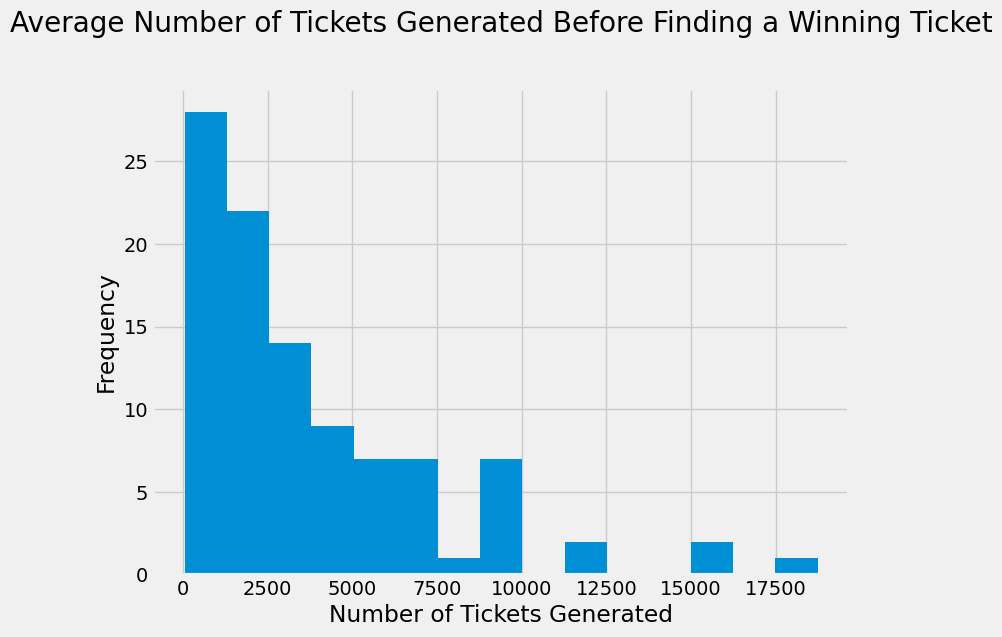

In [45]:
fig = plt.figure(figsize =(8, 6)) 
plt.hist(counts, bins=15)
plt.title("Average Number of Tickets Generated Before Finding a Winning Ticket", y=1.1)
plt.xlabel("Number of Tickets Generated")
plt.ylabel("Frequency")
plt.show()

In [46]:
first_match_counts = pd.Series(counts)
first_match_counts.describe()

count      100.000000
mean      3781.180000
std       3648.650018
min         53.000000
25%       1183.500000
50%       2629.000000
75%       5235.500000
max      18743.000000
dtype: float64

Since the total number of draws is 3,665 and the number of outcomes is 13,983,816, the chance of selecting a winning draw is `3,665/13,983,816` or `1 to 3,815.5`.
So the expected number of tickets we'd need to generate before hitting a winning draw is `3,815.5`. 
Our experiment shows that it takes on average `3,781.18` tickets before generating a winning one, which matches quite nicely with the calculated expected value.

## Multi-ticket Probability <a name="multi_ticket_probability"></a>

We found that the odds of winning with a single ticket are very low.
Does playing multiple tickets make more sense? Let's check.
We're going to write a new function that checks the multi-ticket winning probability, by these guidelines from the engineering team:
* The user will input the number of different tickets they want to play (without inputting the specific combinations they intend to play)
* Our function will see an integer between 1 and 13,983,816 (the maximum number of different tickets)
* The function should print information about the probability of winning the big prize depending on the number of different tickets played

In [36]:
def multi_ticket_probability(n_tickets: int) -> None:
    """
    Calculate and display the probability of winning a 6/49 lottery with multiple tickets.
    
    Computes the odds of winning when playing multiple unique combinations in a single
    lottery draw. Assumes all tickets have different number combinations and displays
    results both as a percentage and as a "1 in X" ratio.
    
    Args:
        n_tickets (int): Number of unique ticket combinations to be played
            Must be between 1 and 13,983,816 (total possible combinations)
            
    Returns:
        None: Results are printed to stdout rather than returned
        
    Examples:
        >>> multi_ticket_probability(1)
        The odds of winning the grand prize by playing one ticket are: 0.0000072%
        In other words, you have a 1 in 13,983,816 chance of winning
        
        >>> multi_ticket_probability(1000)
        The odds of winning the grand prize by playing 1000 tickets are: 0.0071510%
        In other words, you have a 1 in 13,984 chance of winning
    
    Notes:
        - Uses the combinations formula to calculate total possible outcomes (49C6)
        - Assumes all tickets have different number combinations
        - Prints results formatted to 7 decimal places for percentages
        - Uses comma formatting for the "1 in X" odds display
        - Automatically adjusts output text between "one ticket" and "X tickets"
        
    See Also:
        combinations: Used to calculate total possible lottery combinations
    """
    
    # Start by calculating the total number of possible outcomes
    total_outcomes = combinations(49, 6)
    
    # The winning probability is given by N(Successful outcomes) / N(Possible outcomes)
    # The number of successful outcomes is given by the number of tickets the user intends to play
    p_win = n_tickets / total_outcomes
    
    ticket_num_text = "one ticket" if n_tickets == 1 else "{} tickets".format(n_tickets)
    print("The odds of winning the grand prize by playing {} are: {:.7f}%".format(ticket_num_text, p_win * 100))
    print("In other words, you have a 1 in {:,} chance of winning".format(int(1 / p_win)))

In [37]:
inputs = [1, 10, 100, 10000, 1000000, 6991908, 13983816]

for input in inputs:
    multi_ticket_probability(input)
    print()

The odds of winning the grand prize by playing one ticket are: 0.0000072%
In other words, you have a 1 in 13,983,816 chance of winning

The odds of winning the grand prize by playing 10 tickets are: 0.0000715%
In other words, you have a 1 in 1,398,381 chance of winning

The odds of winning the grand prize by playing 100 tickets are: 0.0007151%
In other words, you have a 1 in 139,838 chance of winning

The odds of winning the grand prize by playing 10000 tickets are: 0.0715112%
In other words, you have a 1 in 1,398 chance of winning

The odds of winning the grand prize by playing 1000000 tickets are: 7.1511238%
In other words, you have a 1 in 13 chance of winning

The odds of winning the grand prize by playing 6991908 tickets are: 50.0000000%
In other words, you have a 1 in 2 chance of winning

The odds of winning the grand prize by playing 13983816 tickets are: 100.0000000%
In other words, you have a 1 in 1 chance of winning



As we can see above, every ticket you play increases your chances of winning the grand prize, but you'd need to buy and play almost 14 million tickets in order to guarantee a win.

## Fewer Winning Numbers <a name="fewer_winning_numbers"></a>

In most 6/49 lotteries there are smaller prizes if a player's ticket match two, three, four, or five of the six numbers drawn. As a consequence, the users might be interested in knowing the probability of having two, three, four, or five winning numbers.
So, we're going to write one more function to allow the users to calculate probabilities for fewer than six winning numbers.
The engineering team wants us to be aware of the following:
* Inside the app, the user inputs:
  * six different numbers from 1 to 49; and
  * an integer between 2 and 5 that represents the number of winning numbers expected
* Our function prints information about the probability of having the inputted number of winning numbers.

The following function calculates the probability of matching exactly `n` of the winning numbers:

#### Exact number of winning numbers <a name="exact_number"></a>

In [38]:
def probability_less_6(n: int, print_outcome = True) -> float:
    """
    Calculate the probability of matching exactly n numbers in a 6/49 lottery draw.
    
    Computes the probability of getting exactly n matching numbers (not more, not less) 
    when playing a single ticket in a 6/49 lottery. Uses the hypergeometric probability
    formula by calculating possible combinations of matching and non-matching numbers.
    
    Args:
       n (int): Number of matching numbers to calculate probability for
           Must be between 0 and 6 inclusive
       print_outcome (bool, optional): Whether to print formatted results. Defaults to True
       
    Returns:
       float: Probability of matching exactly n numbers (as a decimal between 0 and 1)
       
    Examples:
       >>> probability_less_6(3)
       The odds of correctly guessing exactly 3 numbers with this ticket are 1.3197069%.
       In other words, your chances are 1 to 76.
       0.013197069499011
       
       >>> probability_less_6(5, print_outcome=False)
       0.000103221769363
    
    Notes:
       - Uses combinations formula to calculate:
         * Ways to choose n numbers from 6 winning numbers
         * Ways to choose (6-n) numbers from 43 non-winning numbers
       - Divides by total possible combinations (49C6) to get probability
       - Prints results with 7 decimal places for percentages
       - Uses comma formatting for the "1 in X" odds display
       
    See Also:
       combinations: Used to calculate various combination values
    """
    
    # Get all the combinations of n numbers out of 6
    combinations_of_n_winning_numbers = combinations(6, n)
    
    # Get all the combinations of the remaining numbers
    # From the (49 - 6 = 43) numbers that didn't win
    combinations_remaining = combinations(43, 6 - n)
    
    # Multiply both to get all successful outcomes
    successful_outcomes = combinations_of_n_winning_numbers * combinations_remaining
    
    total_outcomes = combinations(49, 6)
    
    
    p_n = successful_outcomes / total_outcomes
    
    if print_outcome:
        print("The odds of correctly guessing exactly {} numbers with this ticket are {:.7f}%. In other words, your chances are 1 to {:,}.".format(n, p_n * 100, int(round(1/p_n))))
    
    return p_n

Let's see what are the odds for correctly guessing 2, 3, 4 or 5 numbers:

In [39]:
for n in range(2, 6):
    probability_less_6(n)
    print()

The odds of correctly guessing exactly 2 numbers with this ticket are 13.2378029%. In other words, your chances are 1 to 8.

The odds of correctly guessing exactly 3 numbers with this ticket are 1.7650404%. In other words, your chances are 1 to 57.

The odds of correctly guessing exactly 4 numbers with this ticket are 0.0968620%. In other words, your chances are 1 to 1,032.

The odds of correctly guessing exactly 5 numbers with this ticket are 0.0018450%. In other words, your chances are 1 to 54,201.



#### Minimum number of winning numbers <a name="minimum_number"></a>

In addition to calculating the odds of correctly guessing a specific number of winning numbers we can also calculate the odds of correctly guessing *at least* a number of winning numbers.
The following function does that:

In [40]:
def probability_at_least(n: int, print_outcome = True) -> None:
    """
    Calculate the probability of matching n or more numbers in a 6/49 lottery draw.
    
    Computes the cumulative probability of matching n, n+1, ..., up to 6 numbers
    when playing a single ticket in a 6/49 lottery. This represents the probability
    of getting at least n matches.
    
    Args:
       n (int): Minimum number of matching numbers to calculate probability for
           Must be between 0 and 6 inclusive
       print_outcome (bool, optional): Whether to print formatted results. Defaults to True
       
    Returns:
       None: Results are printed to stdout rather than returned
       
    Examples:
       >>> probability_at_least(4)
       The odds of correctly guessing at least 4 numbers with this ticket are 0.0186442%.
       In other words, your chances are 1 to 5,364.
       
       >>> probability_at_least(6)  # Probability of perfect match
       The odds of correctly guessing at least 6 numbers with this ticket are 0.0000072%.
       In other words, your chances are 1 to 13,983,816.
    
    Notes:
       - Calculates sum of probabilities for exactly n, n+1, ..., 6 matches
       - Uses probability_less_6() function for individual probability calculations
       - Prints results with 7 decimal places for percentages
       - Uses comma formatting for the "1 in X" odds display
       
    See Also:
       probability_less_6: Used to calculate individual match probabilities
       
    Raises:
       ValueError: If n is not between 0 and 6 inclusive
    """
   
    p_n = 0
    for num in range(n, 7):
        p_n += probability_less_6(num, print_outcome=False)
    
    if print_outcome:
        print("The odds of correctly guessing at least {} numbers with this ticket are {:.7f}%. In other words, your chances are 1 to {:,}.".format(n, p_n * 100, int(round(1/p_n))))

In [42]:
for n in range(2, 7):
    probability_at_least(n)
    print()

The odds of correctly guessing at least 2 numbers with this ticket are 15.1015574%. In other words, your chances are 1 to 7.

The odds of correctly guessing at least 3 numbers with this ticket are 1.8637545%. In other words, your chances are 1 to 54.

The odds of correctly guessing at least 4 numbers with this ticket are 0.0987141%. In other words, your chances are 1 to 1,013.

The odds of correctly guessing at least 5 numbers with this ticket are 0.0018521%. In other words, your chances are 1 to 53,992.

The odds of correctly guessing at least 6 numbers with this ticket are 0.0000072%. In other words, your chances are 1 to 13,983,816.



## Next Steps <a name="next_steps"></a>

For the next version of the app we can suggest the following features:
* Add the cost of tickets and the values of the various prizes, to calculate the expected profit (or, more realisticly, expected loss)
* Add comparisons to other unlikely events, to make clear how unlikely winning the lottery is

## Conclusion <a name="conclusion"></a>

In a standard 6/49 lottery there are almost 14 million different ticket combinations. The odds are stacked against the player, and there's no combination that increases them.

With a price of \\$3 per ticket, you'd need to buy about $42 million worth of tickets to guarantee a win, and the prize pot is usually much lower than that amount.

We've created a framework for a first version of an app that helps potential players know the actual odds of winning the lottery, which will hopefully convince them not to spend their money on the game.